# Ideas

- Monitorear Loss en entranamiento y val. Mirar si tiene sentido tener mas epochs o no
- Agregar early stopping
- Preguntar como evaluar en Train con CV (promedio la loss de los train?)
- Probar una red sin transfer learning para solo los posteriors (un canal, dos canales)
- Expandir la idea anterior con una red multimodal compuesta de: una red para los posteriors (punto anterior) y una red para la imagen (puede ser una resnet18 o algo ya entrenado), concatenar y agregar clasificador. Variantes: posteriors podemos probar un canal y dos canales, imagen foveada en fijacion o sin fovear, o con todas las fijaciones anteriores foveadas.
- Siguiendo la idea anterior, en vez de pasarles la imagen entera, se puede pasar un crop del tamaño de la entrada de la red centrado en la fijación, se puede probar foveado. 

In [50]:
import numpy as np
from os import path
import matplotlib.pyplot as plt
from scipy.stats import entropy
from os import listdir
import pandas as pd
from sklearn.metrics import RocCurveDisplay,roc_curve,DetCurveDisplay
from scipy.special import expit
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
import seaborn as sns

In [2]:
#load input cross-val data
tp_data = np.load(path.abspath("target_present_data.npz"))
#obtengo los índices de fin de scanpath
sequence_start_tp = np.where(tp_data["fixations"] == 1)[0]
sequence_end_tp = np.append(sequence_start_tp[1:]-1,[tp_data["fixations"].shape[0]-1])

tp_df= pd.DataFrame.from_dict({item: tp_data[item] for item in tp_data.files if item !='posteriors'}).astype(np.int64).iloc[sequence_end_tp]

ta_data = np.load(path.abspath("target_absent_data.npz"))
#obtengo los índices de fin de scanpath
sequence_start_ta = np.where(ta_data["fixations"] == 1)[0]
sequence_end_ta = np.append(sequence_start_ta[1:]-1,[ta_data["fixations"].shape[0]-1])


ta_df= pd.DataFrame.from_dict({item: ta_data[item] for item in ta_data.files if item !='posteriors'}).astype(np.int64).iloc[sequence_end_ta]

last_fixation_full_data = pd.concat([ta_df,tp_df],axis=0,ignore_index=True)

#load output cross-val validation data
outputs = np.empty(shape=0)
labels = np.empty(shape=0,dtype=np.int32)
fixations = np.empty(shape=0,dtype=np.int32)
scanpath_ids = np.empty(shape=0,dtype=np.int32)

for i in range(1,6):
    dict = np.load(path.abspath(f"gng-outputs-{i}.npz"))
    outputs = np.append(outputs,dict["outputs"])
    labels = np.append(labels,dict["labels"])
    fixations = np.append(fixations,dict["fixations"])
    scanpath_ids = np.append(scanpath_ids,dict["scanpath_ids"])




array([<AxesSubplot:title={'center':'quantile_max_fixations'}>],
      dtype=object)

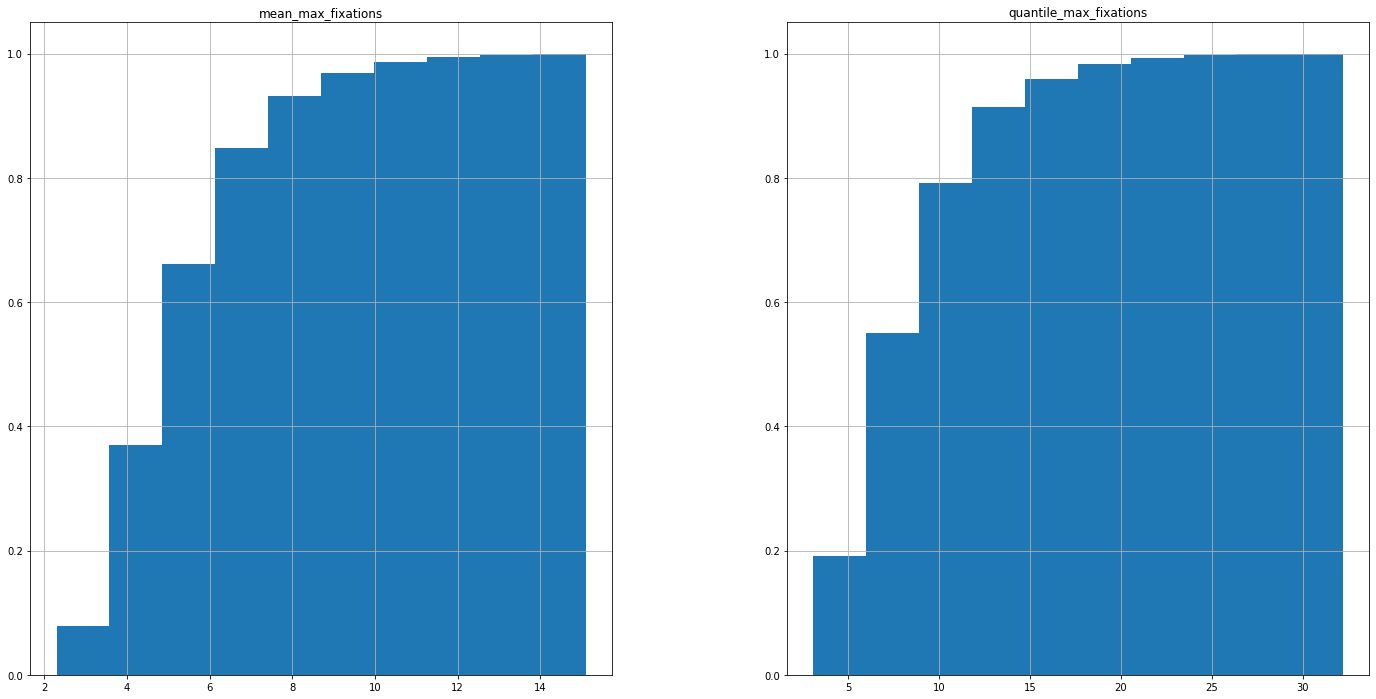

In [3]:
fig, ax = plt.subplots(1, 2, figsize = (24,12))

mean_fixations_by_image = ta_df[["image_ids","fixations"]].groupby(["image_ids"]).mean()
mean_fixations_by_image.columns = ["mean_max_fixations"]
mean_fixations_by_image.reset_index()

quantile_fixations_by_image = ta_df[["image_ids","fixations"]].groupby(["image_ids"]).quantile(0.9)
quantile_fixations_by_image.columns = ["quantile_max_fixations"]
quantile_fixations_by_image.reset_index()


mean_fixations_by_image.hist(cumulative=True,density=True,ax=ax[0])
quantile_fixations_by_image.hist(cumulative=True,density=True,ax=ax[1])


In [4]:
continue_labels_indexes = np.where(labels == 0)[0]
stop_labels_indexes = np.where(labels == 1)[0]
negatives = len(continue_labels_indexes)
positives = len(stop_labels_indexes)
total= positives+negatives
print(total)

print(100.0*positives/total)
print(100.0*negatives/total)

134927
18.301748352813004
81.69825164718699


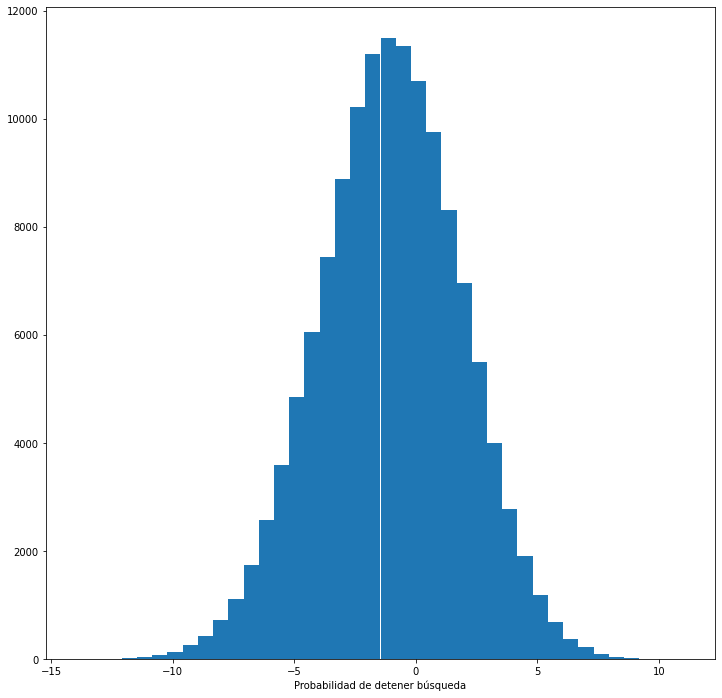

In [5]:
#distribuciones generales

fig, ax = plt.subplots(1, 1, figsize = (12,12))

ax.hist(outputs,bins=40)

ax.set_xlabel("Probabilidad de detener búsqueda");
    


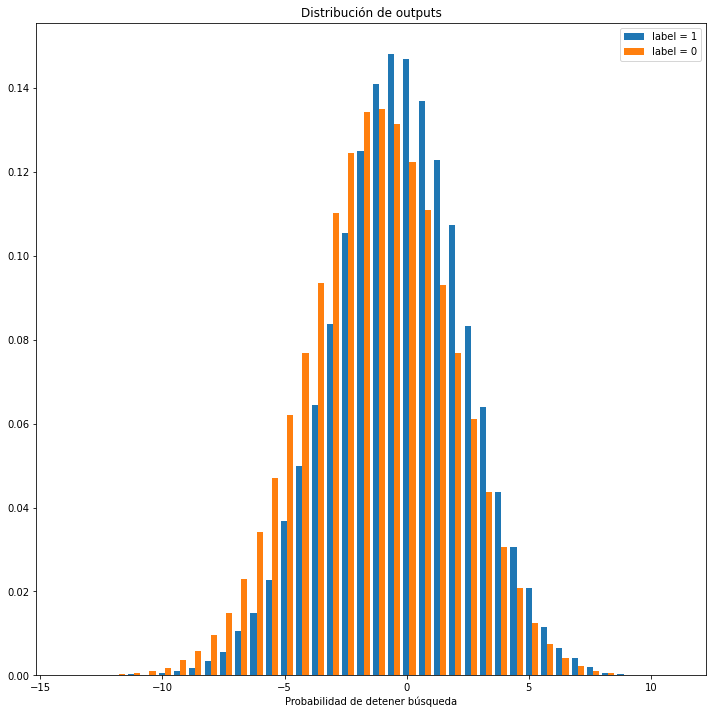

In [6]:
#distribuciones por label
#guardar outputs de entrenamiento para plotear



continue_labels_indexes = np.where(labels == 0)[0]
stop_labels_indexes = np.where(labels == 1)[0]
stop_outputs = outputs[stop_labels_indexes]
continue_outputs = outputs[continue_labels_indexes]
plt.rcParams["figure.figsize"] = (12,12)
plt.title(f"Distribución de outputs")
plt.xlabel("Probabilidad de detener búsqueda")
plt.hist([stop_outputs, continue_outputs], 40, label=['label = 1', 'label = 0'],density=True)
plt.legend(loc='upper right')
plt.show()


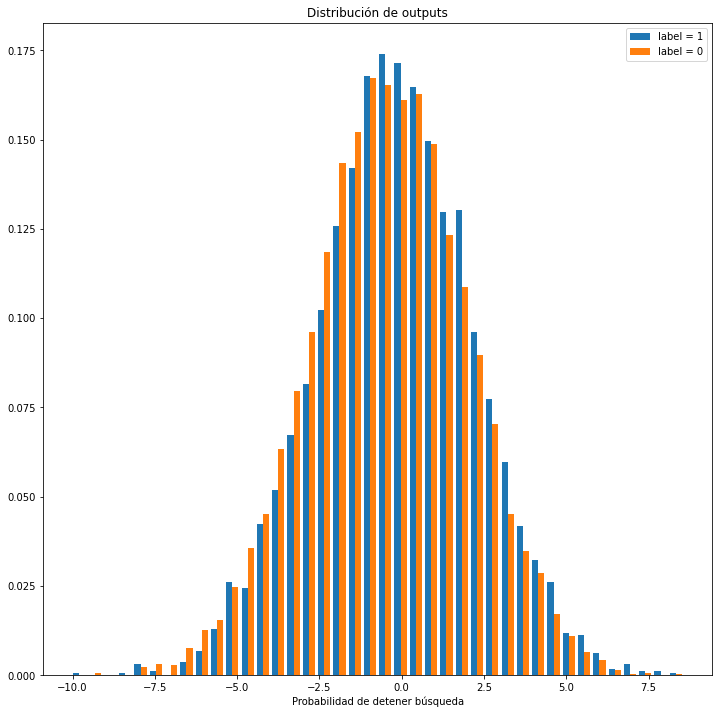

In [7]:
#distribuciones por número de fijación

fixation = 5
fixation_indexes = np.where(fixations == fixation)[0]     
continue_labels_indexes = np.where(labels == 0)[0]
stop_labels_indexes = np.where(labels == 1)[0]
continue_labels_indexes = np.intersect1d(continue_labels_indexes,fixation_indexes)
stop_labels_indexes = np.intersect1d(stop_labels_indexes,fixation_indexes)    
stop_outputs = outputs[stop_labels_indexes]
continue_outputs = outputs[continue_labels_indexes]    
plt.title(f"Distribución de outputs")
plt.xlabel("Probabilidad de detener búsqueda")
plt.hist([stop_outputs, continue_outputs], 40, label=['label = 1', 'label = 0'],density=True)
plt.legend(loc='upper right')
plt.show()

C:\Users\Gonzalo\AppData\Local\Temp\ipykernel_3624\401888610.py:86: RuntimeWarning: invalid value encountered in double_scalars
  tpr_by_fix = np.append(tpr_by_fix,100.0 * true_positives / positives)
C:\Users\Gonzalo\AppData\Local\Temp\ipykernel_3624\401888610.py:87: RuntimeWarning: invalid value encountered in double_scalars
  tnr_by_fix = np.append(tnr_by_fix,100.0 * true_negatives / negatives)
C:\Users\Gonzalo\AppData\Local\Temp\ipykernel_3624\401888610.py:88: RuntimeWarning: invalid value encountered in double_scalars
  acc_by_fix = np.append(acc_by_fix,100.0 * correct / total)


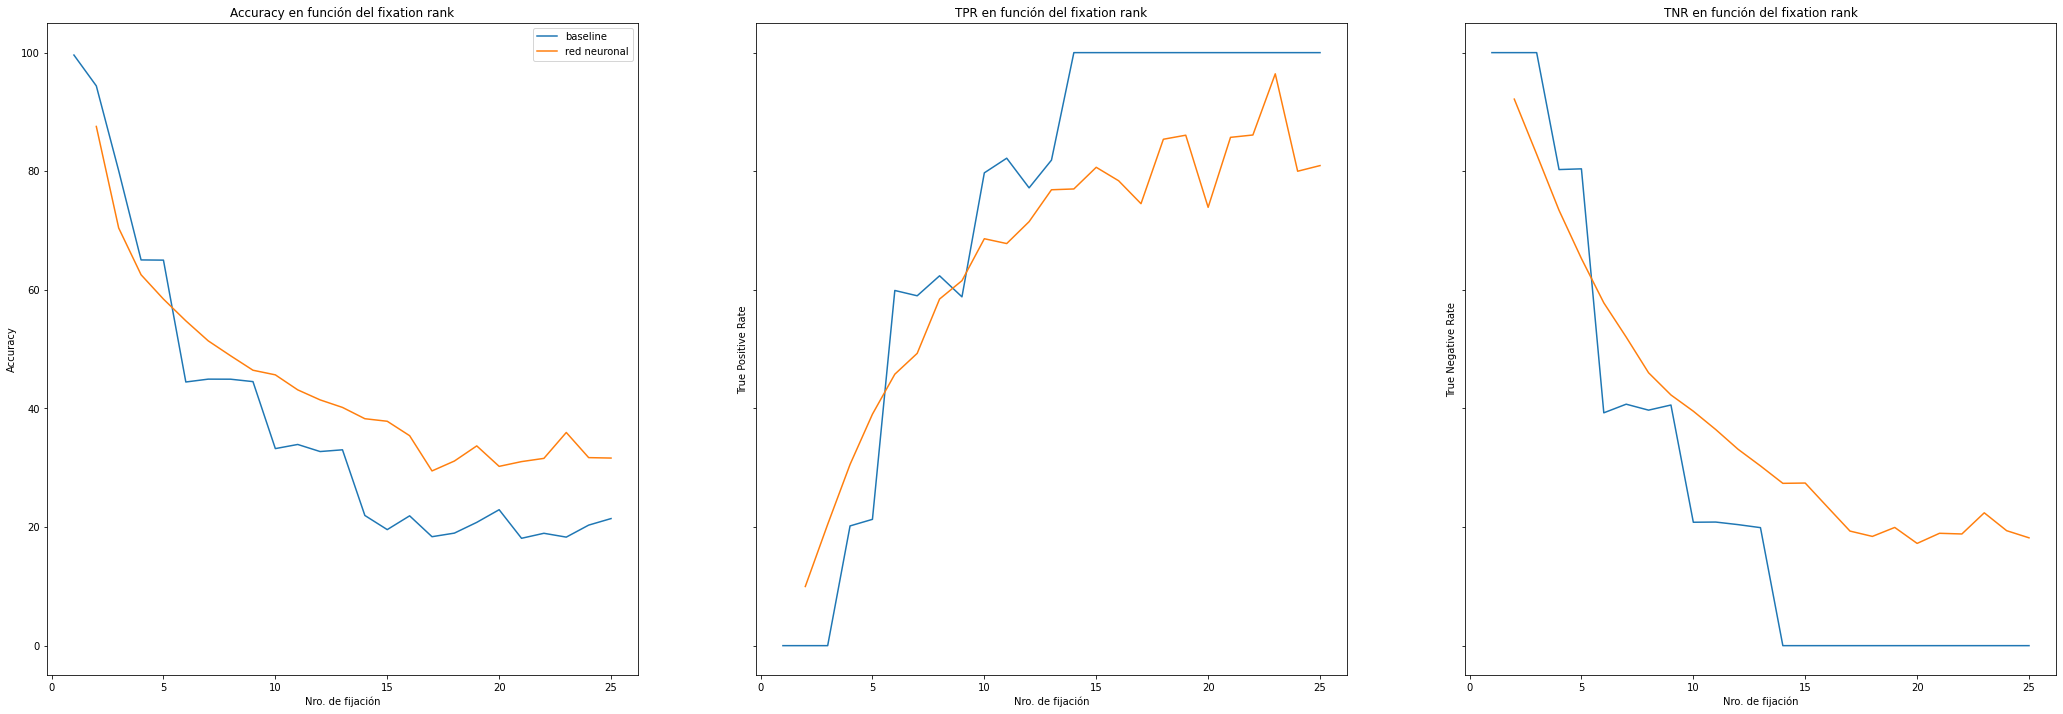

In [8]:
#Baseline Model

input_fixations = np.concatenate((ta_data["fixations"],tp_data["fixations"]))
predictions = np.empty(shape=0,dtype=np.int32)

kfold = StratifiedGroupKFold(n_splits=5, shuffle=True,random_state=321)
#Puedo calcular los umbrales dentro de cada fold de un CV y aplicar la misma idea pero en cada fold.
for fixation in input_fixations:
    if fixation <4:
        proba=0.0
    elif 4 <= fixation <=5:
        proba = 0.2
    elif 6 <= fixation <= 9:
        proba = 0.6
    elif 10 <= fixation <= 13:
        proba = 0.8
    else:
        proba = 1.0
    predictions = np.append(predictions,np.random.binomial(1,proba))

fig, ax = plt.subplots(1, 3, figsize = (36,12),sharey=True)


input_labels = np.concatenate((ta_data["labels"],tp_data["labels"]))
indexes_by_fix_number = []
acc_by_fix = np.empty(shape=(0,))
tpr_by_fix = np.empty(shape=(0,))
tnr_by_fix = np.empty(shape=(0,))

for j in range(1,26):
    indexes_by_fix_number.append(np.where(input_fixations == j)[0])
for array in indexes_by_fix_number:
    labels_by_fix = input_labels[array]
    positives = np.sum(labels_by_fix == 1)
    negatives = np.sum(labels_by_fix == 0)
    predictions_by_fix = predictions[array]
    true_positives = np.sum(np.logical_and(predictions_by_fix,labels_by_fix))
    true_negatives = np.sum(np.logical_not(np.logical_or(predictions_by_fix,labels_by_fix)))
    total = positives + negatives
    correct = true_positives + true_negatives
    
    tpr_by_fix = np.append(tpr_by_fix,100.0 * true_positives / positives)
    tnr_by_fix = np.append(tnr_by_fix,100.0 * true_negatives / negatives)
    acc_by_fix = np.append(acc_by_fix,100.0 * correct / total)
  
ax[0].plot(range(1,26),acc_by_fix,label="baseline")
ax[0].set_title(f"accuracy en función del fixation rank")
ax[0].set_xlabel("Nro. de fijación")
ax[0].set_ylabel("Accuracy")
ax[1].plot(range(1,26),tpr_by_fix,label="baseline")
ax[1].set_title(f"TPR en función del fixation rank")
ax[1].set_xlabel("Nro. de fijación")
ax[1].set_ylabel("True Positive Rate")
ax[2].plot(range(1,26),tnr_by_fix,label="baseline")
ax[2].set_title(f"TNR en función del fixation rank")
ax[2].set_xlabel("Nro. de fijación")
ax[2].set_ylabel("True Negative Rate");






#métricas por número de fijación
#al hacer CV con el baseline, puedo plotear esto en el mismo gráfico


indexes_by_fix_number = []
acc_by_fix = np.empty(shape=(0,))
tpr_by_fix = np.empty(shape=(0,))
tnr_by_fix = np.empty(shape=(0,))

for j in range(1,26):
    indexes_by_fix_number.append(np.where(fixations == j)[0])
for array in indexes_by_fix_number:
    outputs_by_fix = outputs[array]
    labels_by_fix = labels[array]
    positives = np.sum(labels_by_fix == 1)
    negatives = np.sum(labels_by_fix == 0)
    predictions_by_fix = outputs_by_fix >= 0.5 #al tener nuevos resultados meter sigmoidea acá
    true_positives = np.sum(np.logical_and(predictions_by_fix,labels_by_fix))
    true_negatives = np.sum(np.logical_not(np.logical_or(predictions_by_fix,labels_by_fix)))
    total = positives + negatives
    correct = true_positives + true_negatives
    
    tpr_by_fix = np.append(tpr_by_fix,100.0 * true_positives / positives)
    tnr_by_fix = np.append(tnr_by_fix,100.0 * true_negatives / negatives)
    acc_by_fix = np.append(acc_by_fix,100.0 * correct / total)

ax[0].plot(range(1,26),acc_by_fix,label="red neuronal")
ax[0].set_title(f"Accuracy en función del fixation rank")
ax[0].set_xlabel("Nro. de fijación")
ax[0].set_ylabel("Accuracy")
ax[1].plot(range(1,26),tpr_by_fix,label="red neuronal")
ax[1].set_title(f"TPR en función del fixation rank")
ax[1].set_xlabel("Nro. de fijación")
ax[1].set_ylabel("True Positive Rate")
ax[2].plot(range(1,26),tnr_by_fix,label="red neuronal")
ax[2].set_title(f"TNR en función del fixation rank")
ax[2].set_xlabel("Nro. de fijación")
ax[2].set_ylabel("True Negative Rate");
ax[0].legend()



22107 pendientes positivas de 26411 totales
Hay cruces de umbral hacia abajo en 3962 scanpaths


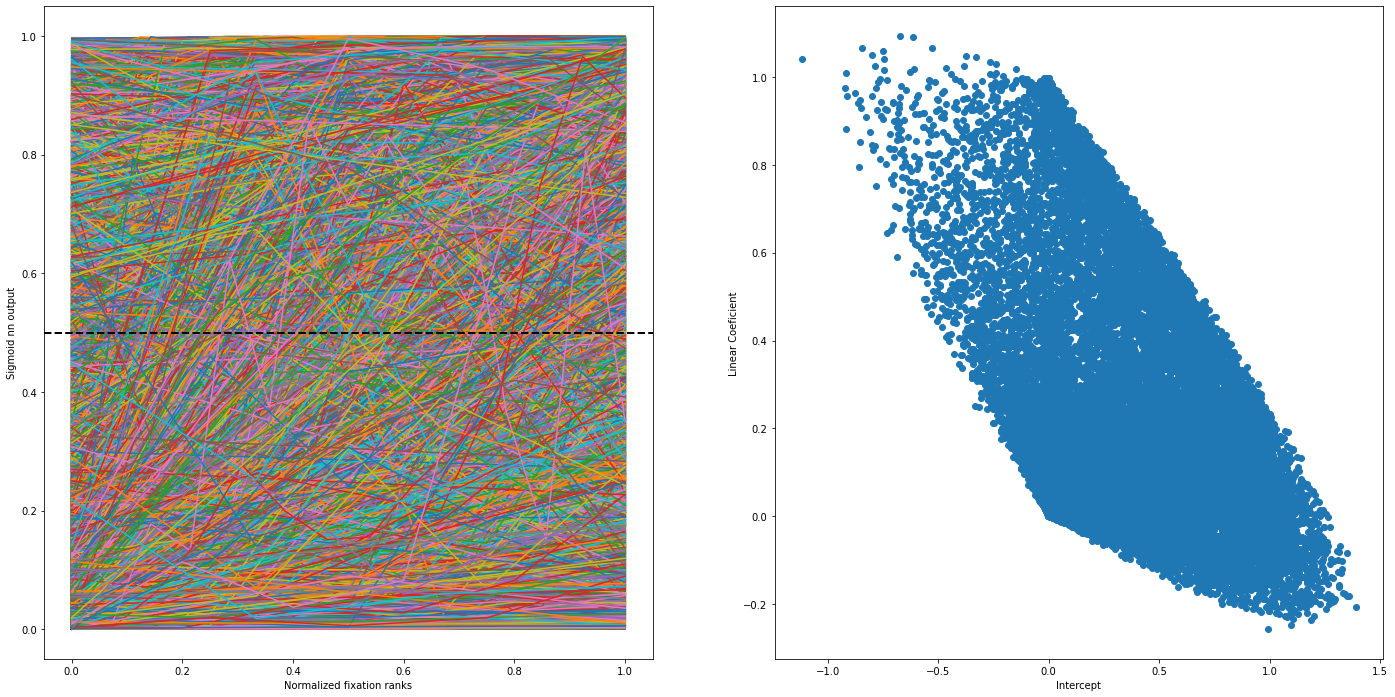

In [49]:
#evolución de valor de output por cada scanpath
scaler = MinMaxScaler()
fig, ax = plt.subplots(1, 2, figsize = (24,12))
sort_idx = np.argsort(scanpath_ids)
a_sorted = scanpath_ids[sort_idx]
unq_first = np.concatenate(([True], a_sorted[1:] != a_sorted[:-1]))
unq_items = a_sorted[unq_first]
unq_count = np.diff(np.nonzero(unq_first)[0])
grouped_indexes = np.split(sort_idx, np.cumsum(unq_count))
filtered_indexes = []
linear_coefs=np.empty(0)
intercepts=np.empty(0)
boundary_crosses = 0
for indexes in grouped_indexes:
    if indexes.shape[0] > 1:
        filtered_indexes.append(indexes)
for indexes in filtered_indexes:
    ordered_fixations_indexes = np.argsort(fixations[indexes])
    scanpaths_outputs = expit(outputs[indexes][ordered_fixations_indexes]).reshape(-1, 1)
    
    #cantidad de cruces de 0.5 para abajo
    filtered_scanpaths = fixations[indexes][ordered_fixations_indexes].reshape(-1, 1)
    crosses_boundary = np.any(np.logical_and(scanpaths_outputs[:-1] >= 0.5,scanpaths_outputs[1:] < 0.5))
    if crosses_boundary:
        boundary_crosses += 1
    regression = LinearRegression().fit(scaler.fit_transform(filtered_scanpaths), scanpaths_outputs)
    linear_coefs = np.append(linear_coefs,regression.coef_)
    intercepts = np.append(intercepts,regression.intercept_)
    filtered_scanpaths_normalized = scaler.fit_transform(filtered_scanpaths)
    ax[0].plot(filtered_scanpaths_normalized.reshape(-1),scanpaths_outputs.reshape(-1))
ax[0].axhline(y=[0.5], color='black', ls='--', lw=2, label='umbral de decisión');
ax[0].set_ylabel("Sigmoid nn output");
ax[0].set_xlabel("Normalized fixation ranks");
#hacer scatterplot de las pendientes y de las ordenadas de dichas regresiones.
ax[1].scatter(linear_coefs,intercepts);
ax[1].set_ylabel("Linear Coeficient");
ax[1].set_xlabel("Intercept");
#calcular regresión para cada scanpath y ver la pendiente, a ver cuántas son positivas
print(f'{linear_coefs[linear_coefs>0].shape[0]} pendientes positivas de {linear_coefs.shape[0]} totales')
print(f'Hay cruces de umbral hacia abajo en {boundary_crosses} scanpaths')




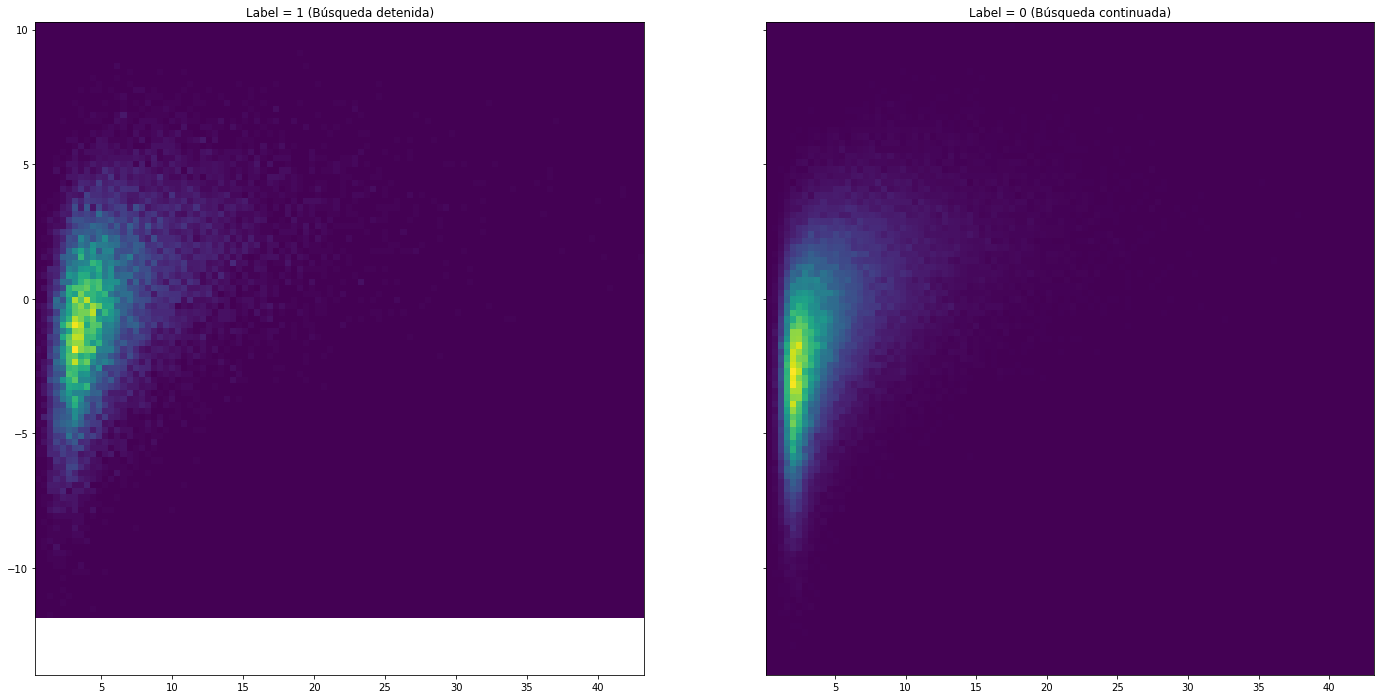

In [68]:
#scatter de número fijación por valor de output
#hacer esto mismo pero con un heatmap
#se le puede agregar ruido al scatter para que no quede tan perfectito
fig, ax = plt.subplots(1, 2, figsize = (24,12),sharey=True)

ax[0].hist2d(fixations[labels==1]+np.random.normal(0, 0.5, fixations[labels==1].shape[0]),outputs[labels==1],bins=100)
ax[1].hist2d(fixations[labels==0]+np.random.normal(0, 0.5, fixations[labels==0].shape[0]),outputs[labels==0],bins=100);

ax[0].set_title("Label = 1 (Búsqueda detenida)")
ax[1].set_title("Label = 0 (Búsqueda continuada)");
#ax[0].scatter(fixations[labels==1],outputs[labels==1],c="blue",label="stop")
#ax[1].scatter(fixations[labels==0],outputs[labels==0],c="darksalmon",label="continue")
#ax[0].legend()
#ax[1].legend();

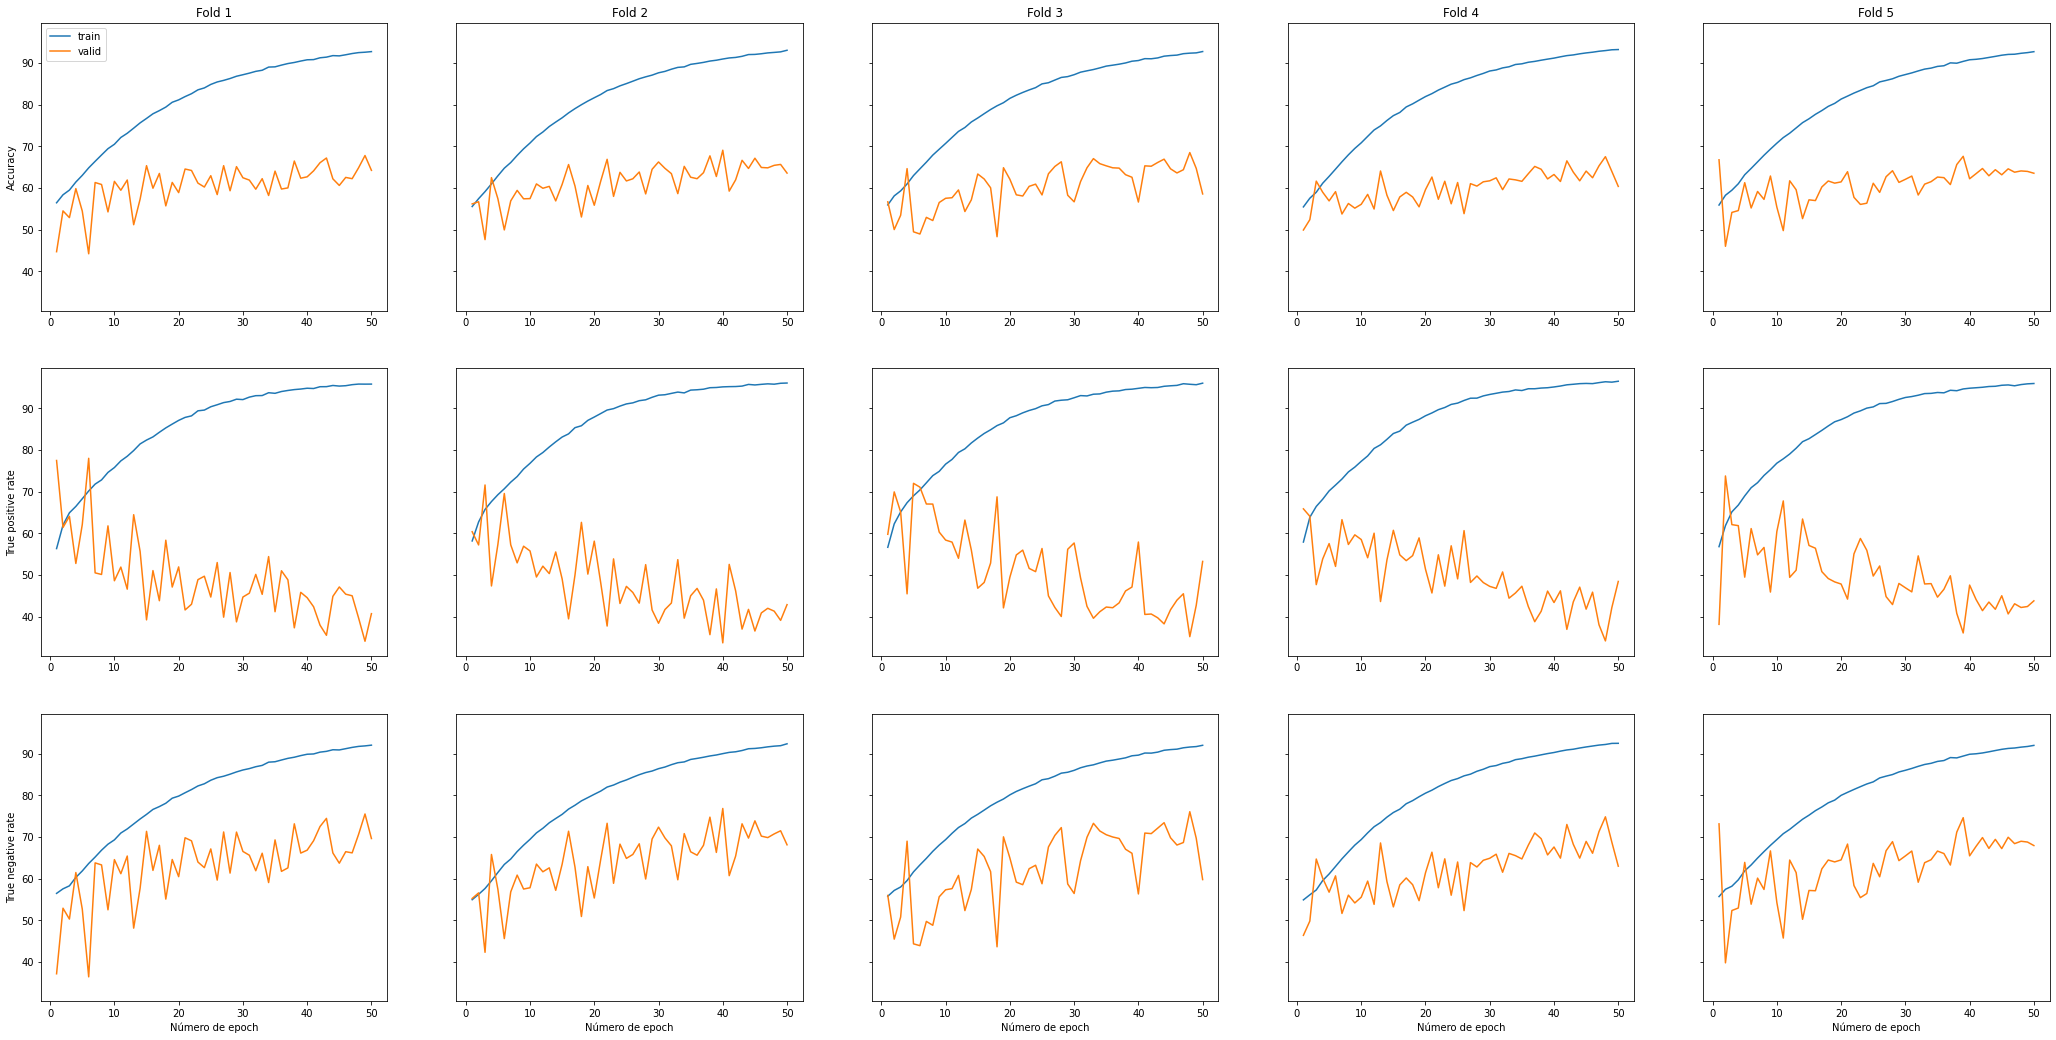

In [11]:
cross_val_data = pd.read_csv("training_info_2channels.csv")
fig, ax = plt.subplots(3, 5, figsize = (36,18),sharey=True)
ax[0][0].set_ylabel("Accuracy")
ax[1][0].set_ylabel("True positive rate")
ax[2][0].set_ylabel("True negative rate")
for i in range(1,6):
    fold_data = cross_val_data[cross_val_data['n_fold']==i]
    training_data = fold_data[fold_data['train']==1.0]
    valid_data = fold_data[fold_data['valid']==1.0]
    ax[0][i-1].set_title(f"Fold {i}")

    ax[2][i-1].set_xlabel("Número de epoch")
    ax[0][i-1].plot(training_data['n_epoch'], training_data['acc'])
    ax[1][i-1].plot(training_data['n_epoch'],training_data['tpr'])
    ax[2][i-1].plot(training_data['n_epoch'],training_data['tnr'])
    ax[0][i-1].plot(valid_data['n_epoch'],valid_data['acc'])
    ax[1][i-1].plot(valid_data['n_epoch'],valid_data['tpr'])
    ax[2][i-1].plot(valid_data['n_epoch'],valid_data['tnr'])


ax[0][0].legend(["train","valid"]);
    

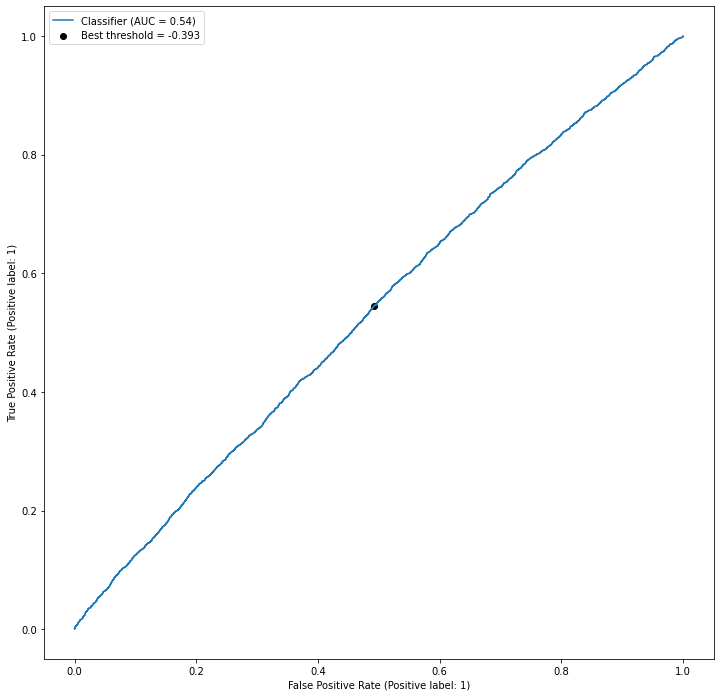

In [12]:

fig, ax = plt.subplots(1, 1, figsize = (12,12))

fixation_indexes = np.where((fixations ==5) )[0] 
filtered_labels = labels[fixation_indexes]
filtered_outputs = outputs[fixation_indexes]
RocCurveDisplay.from_predictions(filtered_labels, filtered_outputs,ax=ax)
fpr, tpr, thresholds = roc_curve(filtered_labels, filtered_outputs)
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
ax.scatter(fpr[ix], tpr[ix], marker='o', color='black', label=f'Best threshold = %.3f' % (thresholds[ix]))
ax.legend();

